
 <img src="https://drive.google.com/uc?id=18x0Fa9XWHlnH5OWkZ-UMrJVQCdsEmYQw" width=300/>
 
## PPGINF 528 TSRI / ICC220 TSBD - NLP [Jul/2023]
## Processamento de Linguagem Natural
#### Professores André Carvalho e Altigran da Silva
#### Aula 4 - Representação de Texto - Laboratório BoW

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
 
# Leitura dos dados
TicketData=pd.read_csv('supportTicketData.csv')
 
# Número de linhas e colunas
print(TicketData.shape)
 
# 10 primeiras linhas
TicketData.head(10)

(19796, 2)


,body,urgency
0,connection issues with assigned address hi fac...,P1
1,cannot access hi cannot access fallowing link ...,P2
2,re address shown valid dear colleagues remarke...,P1
3,sent tuesday critical alert following alert oc...,P2
4,code spelling mistake hello should discover fo...,P2
5,annual leave hello sent last week about previo...,P2
6,report working hello dear last two weeks have ...,P2
7,more access lost access please reset password ...,P1
8,open credentials required please assist instal...,P1
9,dear please ask our supplier for price quotati...,P2


urgency
P1    6748
P2    5528
P3    7520
dtype: int64


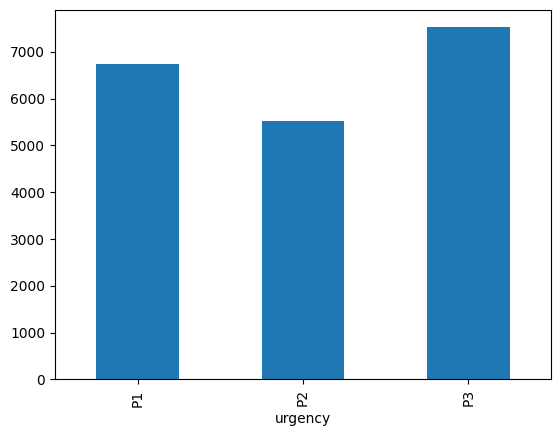

In [3]:

# Número de Tickets por nível de urgencia/prioridade
print(TicketData.groupby('urgency').size())

# Número de Tickets por nível de urgencia/prioridade - Gráfico
%matplotlib inline
TicketData.groupby('urgency').size().plot(kind='bar');


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
 
# O corpus consiste nos textos dos ticketes
# armazenados em "body"
corpus = TicketData['body'].values
 
# Criando o Vetorizador
vectorizer = CountVectorizer(stop_words='english')
 
# Gerando vetores BOW
X = vectorizer.fit_transform(corpus)

In [ ]:
# Organizando os dados

CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
CountVectorizedData['Priority']=TicketData['urgency']
print(CountVectorizedData.shape)
print(CountVectorizedData.head())
y=CountVectorizedData['Priority'].values



In [8]:
# Separa dos dados de treino
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)
 
# Verifica a distribuição dos dados
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13857, 9099)
(13857,)
(5939, 9099)
(5939,)


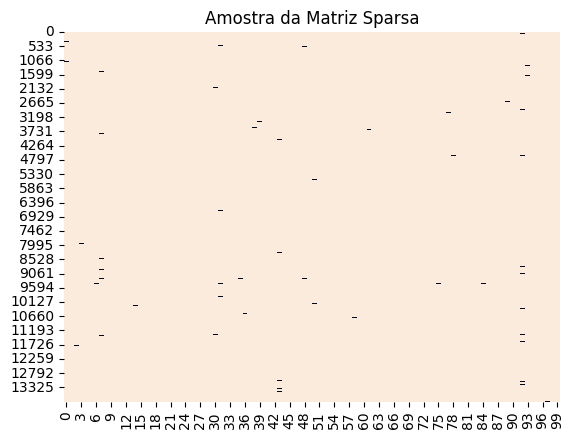

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(X_train.todense()
[:,np.random.randint(0,X_train.shape[1],100)]==0,vmin=0, vmax=1, 
cbar=False).set_title('Amostra da Matriz Sparsa')
plt.show()

In [12]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=10,penalty='l1',solver='saga')

# Treino
LOG=clf.fit(X_train,y_train)

# Teste
prediction=LOG.predict(X_test)
prediction_prob = LOG.predict_proba(X_test)

In [19]:

## Accuracy, Precision, Recall
from sklearn import metrics
accuracy = metrics.accuracy_score(prediction, y_test)
precision = metrics.precision_score(prediction, y_test,average='macro')
recall = metrics.recall_score(prediction, y_test,average='macro')
f1 = metrics.f1_score(prediction, y_test,average='macro')
auc = metrics.roc_auc_score(y_test, prediction_prob,multi_class="ovr")

print("Accuracy:",  round(accuracy,2))
print("Precision:",  round(precision,2))
print("Recall:",  round(recall,2))
print("F1:",  round(f1,2))
print("Auc:", round(auc,2))

Accuracy: 0.75
Precision: 0.72
Recall: 0.73
F1: 0.72
Auc: 0.89


In [20]:
# Metricas por classe
pc_metrics = metrics.precision_recall_fscore_support(prediction, y_test,average=None)
per_class_metrics = pd.DataFrame(pc_metrics,index=['Precison', 'Recall', 'F1','Sup']).drop(['Sup'])
per_class_metrics

,0,1,2
Precison,0.725313,0.461168,0.987735
Recall,0.659226,0.637271,0.887097
F1,0.690692,0.535103,0.934715


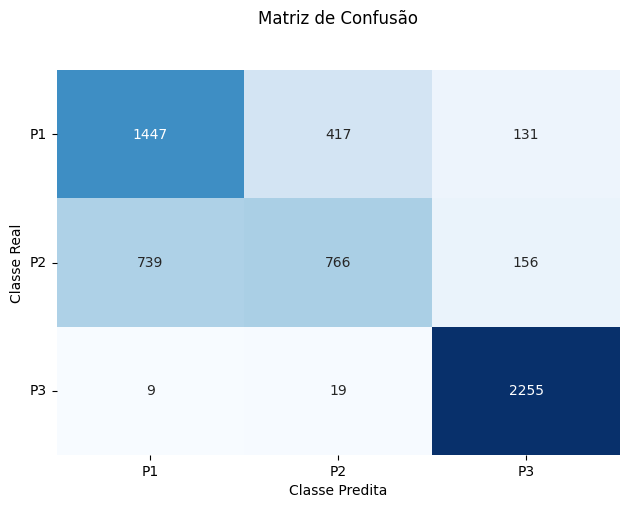

In [21]:
## Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes = np.unique(y_test)
cm = metrics.confusion_matrix(y_test,prediction,)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.tight_layout()
plt.title('Matriz de Confusão', y=1.1)
plt.ylabel('Classe Real')
plt.xlabel('Classe Predita')
plt.show()

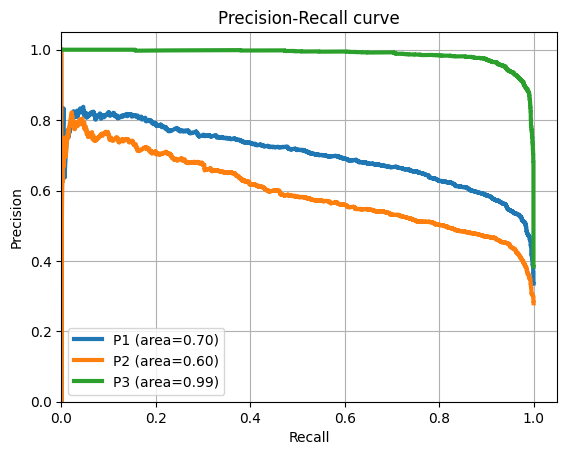

In [22]:
## Plot precision-recall curve
fig, ax = plt.subplots()    
y_test_array = pd.get_dummies(y_test, drop_first=False).values
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], prediction_prob[:,i])
    ax.plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax.set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax.legend(loc="best")
ax.grid(True)
plt.show()

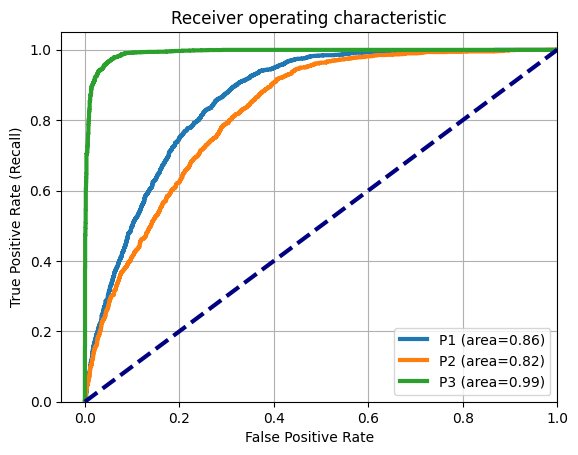

In [23]:
## Plot roc
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           prediction_prob[:,i])
    ax.plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax.set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax.legend(loc="lower right")
ax.grid(True)